# Статистический анализ данных сервиса аренды самокатов

## Введение

   **Цель проекта:**  проанализировать данные сервиса аренды самокатов GoFast и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
  
   **Данные:**  данные сервиса GoFast  за 2021 год о некоторых пользователях из нескольких городов, а также об их поездках и условиях подписки. 
  
   **План выполнения проекта:**
  
  
- Загрузить и изучить данные.


- Сделать предобработку:
 
   - Привести столбец date к типу даты pandas.
  
  
   - Создать новый столбец с номером месяца на основе столбца date.
 
 
   - Проверить наличие и при необходимости обработать пропуски и дубликаты.
 
 
- Провести исследовательский анализ данных:
   
   - Описать и визуализировать общую информацию о пользователях и поездках:
   

   
- Объединить данные о пользователях, поездках и подписках в один датафрейм.
   
   
- Создать из объединенного датафрейма ещё два:

   
   - Визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.
   
   
- Подсчитать выручку:

   - Создать датафрейм с агрегированными данными о поездках на основе объединенного датафрейма и найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
      
   - В этот же датафрейм добавить столбец с помесячной выручкой, которую принёс каждый пользователь.

     
- Проверить гипотезы:     
       
   - Тратят ли пользователи с подпиской больше времени на поездки? 
      
   - Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
   
   - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
    
   - Предложить тест для проверки гипотезы на основе данных до и после обновления: 

     - Снизилось ли значимо количество обращений в техподдержку после того, как техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение?  
     
     
- Решить два дополнительных кейса на распределения:

   -  Подобрать параметры распределения, построить график распределения и сформулировать ответ на вопрос о минимальном количестве промокодов, которые необходимо разослать пользователям, чтобы при вероятности успеха 10%, с вероятностью невыполнения плана 5% минимум 100 из них продлили подписку.
    
   - С помощью аппроксимации построить примерный график распределения и оценить вероятность открытия получателями не более 399,5 тыс. push-уведомлений из 1 млн., при вероятности успеха 40%.
    

- Сформулировать и оформить промежуточный и общий выводы.           

In [1]:
# загружаем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy import stats
from math import factorial
from scipy.stats import binom, norm
import random
import plotly.express as px

# увеличиваем максимальное количество отображающихся столбцов и строк
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# меняем отображение вещественных чисел в e-формате на нормальный
pd.options.display.float_format = '{:.2f}'.format

## Загрузка данных

In [2]:
# читаем исходные данныеи сохраняем в датафреймы
df_users = pd.read_csv('/datasets/users_go.csv', sep=',')
df_rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
df_subs = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')

In [3]:
# выводим общую информацию
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
# читаем первые строки
df_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
# выводим общую информацию
df_rides.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
# читаем первые строки
df_rides.head()

,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28


In [7]:
# выводим общую информацию
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
# читаем таблицу
df_subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### Вывод по первому шагу 

- Загрузили и изучили данные в загруженных датафреймах:


   - **Первая таблица:**
   
-  **'df_users'**
   
   - данные о пользователях: идентификатор, имя, возраст, город и тип подписки (free, ultra);
   
   - пропусков нет, размер небольшой, типы данных верные. 
   
   
   - **Вторая таблица:**

-  **'df_rides'**  
   
   - данные о поездках: идентификатор пользователя, расстояние в текущей сессии (в метрах), продолжителность сессии (в минутах) от начала поездки до завершения, дата совершения поездки;    
   
   - пропусков нет, размер (количество строк) в 11,5 раза больше первой таблицы, тип данных в столбце с датой неверный.
   
   
   - **Третья таблица:**   

-  **'df_subs'** 

   - данные о подписке: стоимость одной минуты поездки по данной подписке, стоимость начала поездки, стоимость ежемесячного платежа;
   
   - таблица совсем маленькая, фактически - справочник.

## Предобработка данных

In [9]:
# приводим данные в столбце с датой к формату даты
df_rides['date'] = pd.to_datetime(df_rides["date"], format='%Y-%m-%d')

# проверяем
df_rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [10]:
# создаем новый столбцец с номером месяца
df_rides['month'] = df_rides['date'].dt.month

# проверяем
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [11]:
# прверяем за какой период собраны данные
print(df_rides['date'].min(), df_rides['date'].max())
df_rides['month'].min(), df_rides['month'].max()

2021-01-01 00:00:00 2021-12-30 00:00:00


(1, 12)

In [12]:
# пропусков в данных нет, проверяем на дубликаты
display(df_rides.duplicated().sum())
df_users.duplicated().sum()

0

31

In [13]:
# выводим все строки - дубликаты
df_users.loc[df_users.duplicated(keep=False)].sort_values(by='user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
46,47,Юрий,28,Тюмень,ultra
1555,72,Никита,25,Москва,ultra
71,72,Никита,25,Москва,ultra
1549,108,Влада,29,Тюмень,ultra
107,108,Влада,29,Тюмень,ultra


In [14]:
# удаляем выяленные дубликаты
df_users = df_users.drop_duplicates(subset='user_id')
# сбрасываем индексы
df_users = df_users.reset_index(drop=True)

# проверяем
df_users.duplicated().sum()

0

In [15]:
# снова смотрим инфо 
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


### Вывод по второму шагу

   - Привели столбец **date** в таблице **df_rides** к **типу даты** pandas.
   
   - **Создали** там же новый **столбец month** с номером месяца на основе столбца date.
   
   - Обнаружили и **удалили дубликаты** в таблице **df_users**.

## Исследовательский анализ данных

In [16]:
# выясняем частоту встречаемости городов (количество пользователей по городам)
df_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

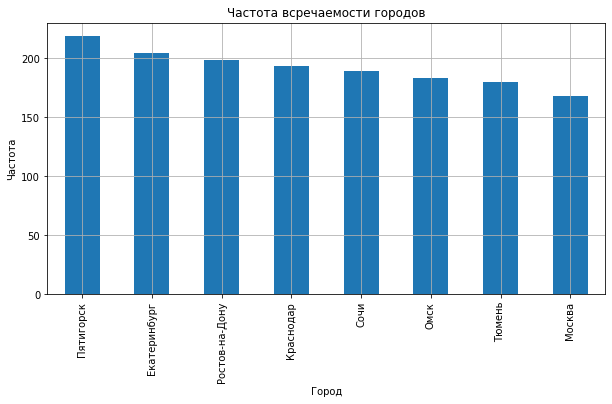

In [17]:
# строим график частоты встречаемости городов 
df_city = df_users['city'].value_counts()
df_city.plot(
    kind='bar',
    grid=True,
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Город')
plt.ylabel('Частота')
plt.title('Частота всречаемости городов')
plt.show()

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера ✔️</b>

Да, так нагляднее! 👍

In [18]:
# находим соотношение числа пользователей с подпиской и без нее
users_all = len(df_users['subscription_type'])
users_free = len(df_users[df_users['subscription_type']=='free'])
users_ultra = len(df_users[df_users['subscription_type']=='ultra'])

print('Число пользователей без подписки:', users_free)
print('Число пользователей с подпиской:', users_ultra)
print('Общее число пользователей:', users_all)
print('Доля пользователей без подписки от общего числа пользователей:',
      round(users_free/users_all*100,2), '%.')
print('Доля пользователей с подпиской от общего числа пользователей:', 
      round(users_ultra/users_all*100,2),'%.')

Число пользователей без подписки: 835
Число пользователей с подпиской: 699
Общее число пользователей: 1534
Доля пользователей без подписки от общего числа пользователей: 54.43 %.
Доля пользователей с подпиской от общего числа пользователей: 45.57 %.


Распредление пользователей с подпиской и без и доля пользователей без подписки

subscription_type  free  ultra   All  share
city                                       
Москва               84     84   168   0.50
Омск                 92     91   183   0.50
All                 835    699  1534   0.54
Тюмень               98     82   180   0.54
Сочи                103     86   189   0.54
Екатеринбург        112     92   204   0.55
Ростов-на-Дону      109     89   198   0.55
Пятигорск           125     94   219   0.57
Краснодар           112     81   193   0.58


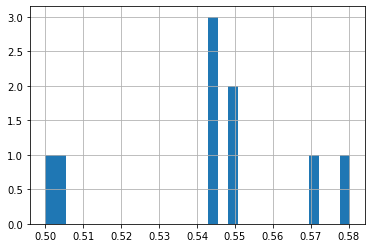

Доля пользователей без подписки по городам


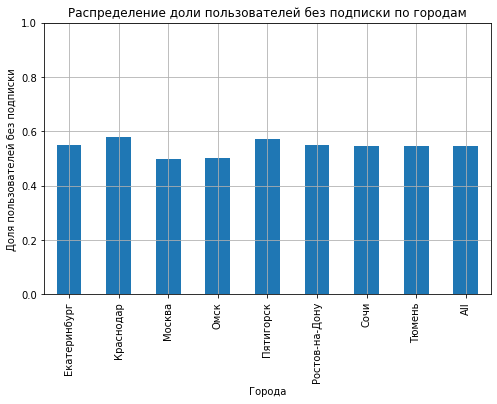

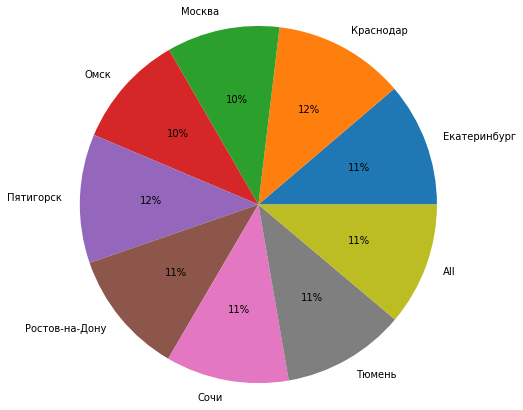

In [19]:
# в качестве дополнения посмотрим распределение по городам пользователей с подпиской и без
df_users_sub_city = df_users.pivot_table(
    index='city',
    values='user_id',
    columns='subscription_type',
    aggfunc='count',
    margins=True,
)
# добавим в группировку столбец с расчетом доли пользователей без подписки 
df_users_sub_city['share'] =  df_users_sub_city['free']/df_users_sub_city['All']
print('Распредление пользователей с подпиской и без и доля пользователей без подписки')
print()
print(df_users_sub_city.sort_values(by='share'))

# строим гистограмму распределения доли пользователей без подписки
df_users_sub_city['share'].hist(bins=30);
plt.show()

# строим круговую диаграмму распределения доли пользователей 
# без подписки по городам
print('Доля пользователей без подписки по городам')
df_users_sub_city.plot(
    kind='bar',
    y='share',
    figsize=(8,5),
    ylim=(0,1),
    grid=True,
    legend=False 
);
plt.xlabel('Города')
plt.ylabel('Доля пользователей без подписки')
plt.title('Распределение доли пользователей без подписки по городам')  
plt.show()

df_users_sub_city.plot(
    kind='pie',
    y='share',
    figsize=(8,5),
    ylim=(0,1),
    grid=True,
    legend=False,
    label=' ',
    autopct='%1.0f%%'    
);
plt.show()

In [20]:
# выводим основные параметры данных по возрасту 
df_users['age'].describe()

count   1534.00
mean      24.90
std        4.57
min       12.00
25%       22.00
50%       25.00
75%       28.00
max       43.00
Name: age, dtype: float64

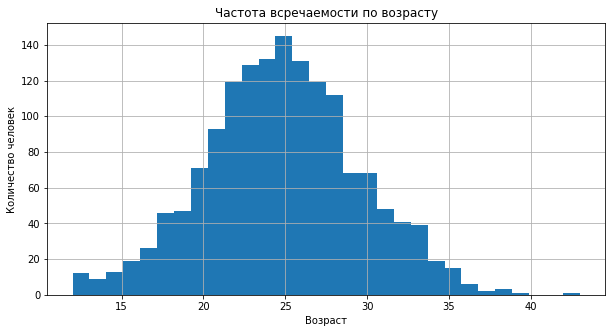

In [21]:
# строим гистограмму по возрасту 
df_users['age'].hist(
    bins=(30),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Возраст')
plt.ylabel('Количество человек')
plt.title('Частота всречаемости по возрасту')
plt.show()

In [22]:
# выводим основные параметры данных по расстоянию, 
# которое пользователь преодолел за одну поездку
df_rides['distance'].describe()

count   18068.00
mean     3070.66
std      1116.83
min         0.86
25%      2543.23
50%      3133.61
75%      3776.22
max      7211.01
Name: distance, dtype: float64

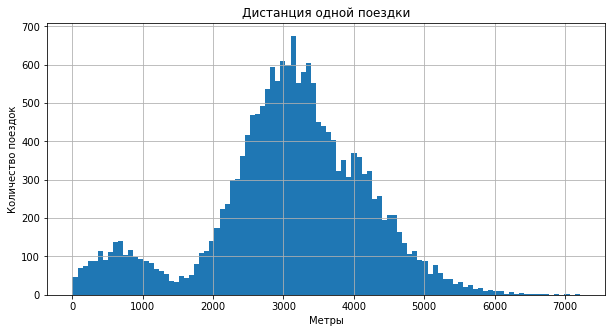

In [23]:
# строим гистограмму по расстоянию за одну поездку 
df_rides['distance'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Метры')
plt.ylabel('Количество поездок')
plt.title('Дистанция одной поездки')
plt.show()

In [24]:
# выводим основные параметры данных по продолжительности поездки
df_rides['duration'].describe()

count   18068.00
mean       17.81
std         6.09
min         0.50
25%        13.60
50%        17.68
75%        21.72
max        40.82
Name: duration, dtype: float64

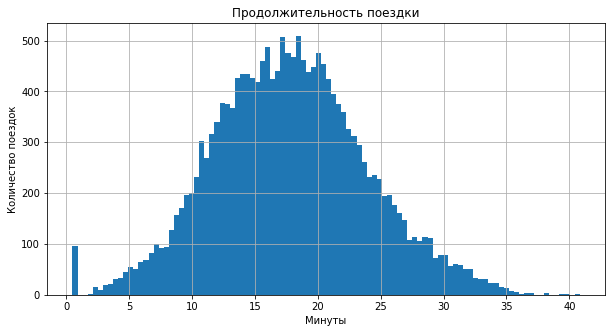

In [25]:
# строим гистограмму по продолжительности поездки
df_rides['duration'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Минуты')
plt.ylabel('Количество поездок')
plt.title('Продолжительность поездки')
plt.show()

### Вывод по третьему шагу 

   - Выяснили частоту встречаемости городов (количество пользователей по городам): 
     
       - **чаще** всего в данных встречается **Пятигорск**. **Реже** всего - **Москва**. 
       
       	              
   - Нашли соотношение числа пользователей с подпиской и без нее:
   
       - Число пользователей **без подписки**: **835**
       - Число пользователей **с подпиской**: **699**
       - **Общее число** пользователей: **1534**
       - **Доля** пользователей **без подписки** от общего числа пользователей: **54.43 %**
       - **Доля** пользователей **с подпиской** от общего числа пользователей: **45.57 %**
       
       
   - Посмотрели распределение пользователей с подпиской и без по городам:
   
      - **больше всего** доля пользователей **без подписки в Краснодаре** (58%), **меньше** всего - в **Москве и Омске** (50%).
  
  
   - Изучили возраст пользователей:
   
             count     1534.00
              mean       24.90
               std        4.57
               min       12.00
               25%       22.00
               50%       25.00
               75%       28.00
               max       43.00
               
       - **распределение** данных по возрасту - близко к **нормальному**: **среднее и медиана** практически равны (**25 лет**) и встречаются чаще всего. Стандартное отклонение маленькое.
       
       
   - Изучили данные о расстоянии, которое пользователь преодолел за одну поездку:
   
             count     18068.00
              mean      3070.66
               std      1116.83
               min         0.86
               25%      2543.23
               50%      3133.61
               75%      3776.22
               max      7211.01
               
      - данные **распределены почти нормально**. Стандартное отклонение маленькое. **Половина** пользователей **проезжает** за одну сессию **больше 3,13 км**., другая **половина - меньше**. **Среднее - 3,07 км**. Небольшой **провал** в районе **1500 метров**, как бы разделяющий данные на два распределения: **короткие поездки** -  0-1500 с пиком в 500м, и **длинные поездки** - 1500 и выше с пиком в 3000м. Возможно это связано с особенностями тарификации, проведением акций или уровнем заряд самоката.        
               
               
               
   - Изучили основные данные о продолжительности поездки:
      
             count     18068.00
              mean        17.81
               std         6.09
               min         0.50
               25%        13.60
               50%        17.68
               75%        21.72
               max        40.82
      
      - **распределение практически нормальное**. Стандартное отклонение маленькое. Продолжительность сессии **в среднем** чуть меньше **18 минут**, что почти совпадает с медианой и самыми частыми значениями. Есть **выброс** в районе нуля (**30 секунд**), что, вероятно, связано c регистрацией при первом использовании, ведь тарификация поминутная.    

## Объединение данных

In [26]:
# объединяем данные о пользователях, поездках и подписках
df_users_riders = pd.merge(
    df_users, df_rides,
    on='user_id',
    how='left'
)

df_total = pd.merge(
    df_users_riders, df_subs,
    on='subscription_type',
    how='left'
)

# проверяем
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [27]:
# выводим пять первых и последних строк
display(df_total.tail())
df_total.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
18063,1534,Альберт,25,Краснодар,free,3781.10,19.82,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.41,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.44,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.67,2021-11-27,11,8,50,0
18067,1534,Альберт,25,Краснодар,free,2371.71,15.89,2021-12-29,12,8,50,0


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.27,2021-08-28,8,6,0,199


In [28]:
# cоздаем датафрейм c данными о пользователях без подписки
df_total_free = df_total.loc[df_total['subscription_type'] == 'free']
# проверяем
df_total_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,14.94,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.23,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20.02,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,9.78,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17.43,2021-02-14,2,8,50,0


In [29]:
# создаем датафрейм с данными о пользователях с подпиской
df_total_ultra = df_total.loc[df_total['subscription_type'] == 'ultra']
# проверяем
df_total_ultra.tail()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6495,699,Оксана,22,Москва,ultra,3973.05,24.67,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.70,15.89,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.16,14.39,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.85,15.84,2021-10-17,10,6,0,199
6499,699,Оксана,22,Москва,ultra,3202.89,25.22,2021-12-03,12,6,0,199


In [30]:
# проверяем размер и отсутствие пропусков в созданных датафреймах
print(df_total.shape, df_total_free.shape, df_total_ultra.shape)

df_total_free.isna().sum()+df_total_ultra.isna().sum()

(18068, 12) (11568, 12) (6500, 12)


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

count   11568.00
mean       17.39
std         6.33
min         0.50
25%        12.96
50%        17.33
75%        21.59
max        34.95
Name: duration, dtype: float64

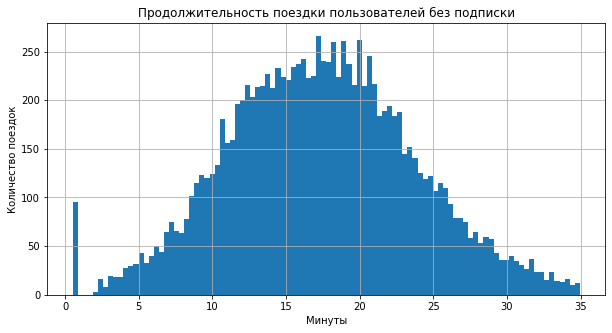

In [31]:
# визуализируем информацию о продолжительности поездок пользователей без подписки
display(df_total_free['duration'].describe())

df_total_free['duration'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Минуты')
plt.ylabel('Количество поездок')
plt.title('Продолжительность поездки пользователей без подписки')
plt.show()

count   6500.00
mean      18.54
std        5.57
min        3.76
25%       14.52
50%       18.18
75%       21.88
max       40.82
Name: duration, dtype: float64

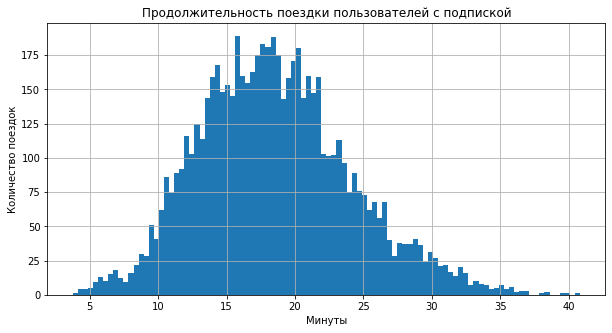

In [32]:
# визуализируем информацию о продолжительности поездок пользователей с подпиской
display(df_total_ultra['duration'].describe())

df_total_ultra['duration'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Минуты')
plt.ylabel('Количество поездок')
plt.title('Продолжительность поездки пользователей с подпиской')
plt.show()

,free,ultra
count,11568.00,6500.00
mean,17.39,18.54
std,6.33,5.57
min,0.50,3.76
25%,12.96,14.52
50%,17.33,18.18
75%,21.59,21.88
max,34.95,40.82


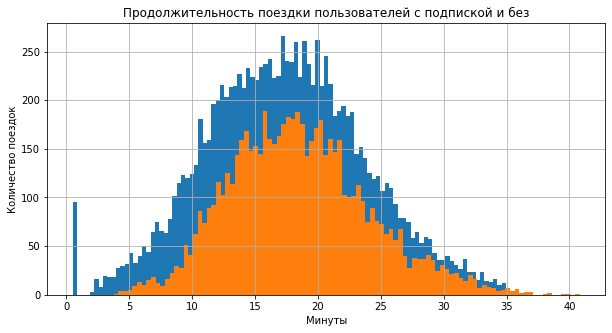

In [33]:
# объединяем статистику и графики для лучшей визуализации
df_duration_describe_join = pd.concat(
    [(df_total_free['duration'].describe()),
    (df_total_ultra['duration'].describe())],
    axis = 1,
    keys= ['free', 'ultra']
)

display(df_duration_describe_join)

df_total_free['duration'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

df_total_ultra['duration'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Минуты')
plt.ylabel('Количество поездок')
plt.title('Продолжительность поездки пользователей с подпиской и без')
plt.show()

count   11568.00
mean     3045.50
std      1246.17
min         0.86
25%      2366.56
50%      3114.65
75%      3905.70
max      7211.01
Name: distance, dtype: float64

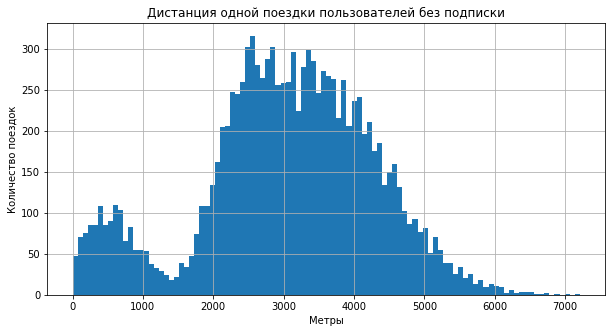

In [34]:
# визуализируем информацию о расстоянии поездок пользователей без подписки
display(df_total_free['distance'].describe())

df_total_free['distance'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Метры')
plt.ylabel('Количество поездок')
plt.title('Дистанция одной поездки пользователей без подписки')
plt.show()

count   6500.00
mean    3115.45
std      836.90
min      244.21
25%     2785.44
50%     3148.64
75%     3560.57
max     5699.77
Name: distance, dtype: float64

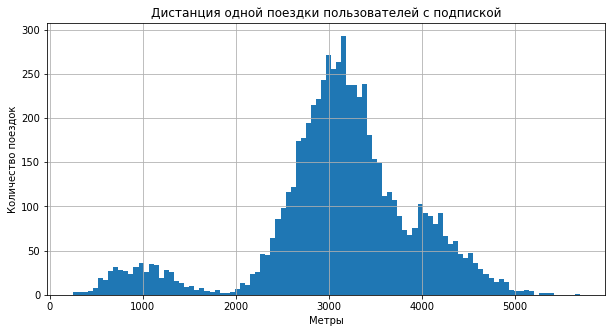

In [35]:
# визуализируем информацию о расстоянии поездок пользователей с подпиской
display(df_total_ultra['distance'].describe())

df_total_ultra['distance'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False 
);

plt.xlabel('Метры')
plt.ylabel('Количество поездок')
plt.title('Дистанция одной поездки пользователей c подпиской')
plt.show()

,free,ultra
count,11568.00,6500.00
mean,3045.50,3115.45
std,1246.17,836.90
min,0.86,244.21
25%,2366.56,2785.44
50%,3114.65,3148.64
75%,3905.70,3560.57
max,7211.01,5699.77


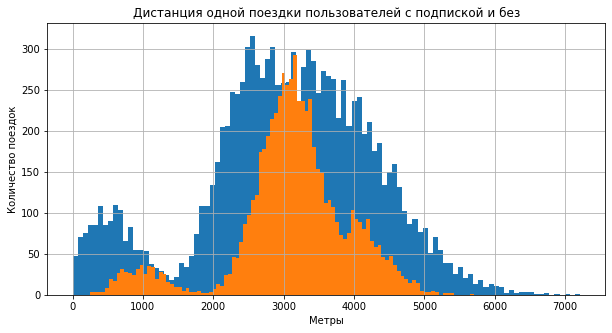

In [36]:
# объединяем статистику и графики для лучшей визуализации
df_distance_describe_join = pd.concat(
    [(df_total_free['distance'].describe()),
    (df_total_ultra['distance'].describe())],
    axis = 1,
    keys= ['free', 'ultra']
)

display(df_distance_describe_join)

df_total_free['distance'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False    
);

df_total_ultra['distance'].hist(
    bins=(100),
    figsize =(10,5),
    legend=False
);

plt.xlabel('Метры')
plt.ylabel('Количество поездок')
plt.title('Дистанция одной поездки пользователей c подпиской и без')
plt.show()

### Вывод по четвертому шагу

   - Создали единый датафрейм: **'df_total'** с данными о пользователях, поездках и подписках.
   
   - Создали ещё два датафрейма из датафрейма 'df_total':
     
     - **'df_total_free'** c данными о пользователях **без подписки**;
     
     - **'df_total_ultra'** с данными о пользователях **с подпиской**.
   
   
   - Визуализировали информацию о пользователях обеих категорий (с подпиской и без неё): 
      
     - **о продолжительности поездок**: 
      
        - оба **распределения близки к нормальным** и имеют схожие параметры, но **"колокол" пользователей с подпиской меньше** (так как данных меньше почти в два раза) и **смещен правее**, то есть **поездки** подписчиков **более продолжительные**. При этом, видна разница в условиях тарификации: у пользователей **без подписки** виден **выброс** в районе нуля (**30 секунд**), в то время как **у подписчиков минимальное** зафиксированное **время - около 4 минут**.
        
     - **о расстоянии поездок**: 

        -  распределения почти повторяют друг друга, но видна **разница в поведении пользователей** в зависимости **от условий оплаты**: пользователи **без подписки** совершают **короткие поездки** в среднем на **500 метров**, а **подписчики - на 1000**; с длинными поездками по-другому: хоть в среднем обе категории пользователей проезжают в среднем почти равное расстояние, **пользователи без подписки** чаще **проезжают более длинные дистанции**.    

## Подсчёт выручки

- Создадим датафрейм с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц.

In [37]:
# округляем значения в исходном столбце duration до целого
df_total['duration'] = np.ceil(df_total['duration'])

# создаем группировку с суммарной дистанцией и продолжительностью поездок 
# по юзерам и месяцам
df_total_metrics_sum = df_total.pivot_table(
    index=('user_id','month'),
    values=('distance','duration'), 
    aggfunc='sum',
)
# создаем группировку с количеством поездок по юзерам и месяцам
df_total_metrics_count = df_total.pivot_table(
    index=('user_id','month'),
    values='name', 
    aggfunc='count',
)
# объединяем две группировки
df_total_metrics = pd.concat(
    [df_total_metrics_sum, 
     df_total_metrics_count],
     axis=1
)
# сбрасываем индексы
df_total_metrics = df_total_metrics.reset_index()

# переименовываем столбцы
df_total_metrics = df_total_metrics.rename(
    columns = {'user_id':'user_id',
               'distance':'distance',
               'duration':'duration',
               'name':'count'
              }
)

# проверяем
df_total_metrics.tail()

,user_id,month,distance,duration,count
11326,1534,6,3409.47,26.00,2
11327,1534,8,7622.45,48.00,2
11328,1534,9,4928.17,23.00,1
11329,1534,11,13350.02,78.00,4
11330,1534,12,2371.71,16.00,1


- Добавим столбец с типом подписки.

In [38]:
# создаем датафрейм со столбцами user_id и subscription_type
df_users_subs = df_users[['user_id','subscription_type']]

# объединяем таблицы по user_id
df_total_metrics = pd.merge(
    df_total_metrics, df_users_subs,
    on='user_id',
    how='left'
)
# проверяем
df_total_metrics.head()

,user_id,month,distance,duration,count,subscription_type
0,1,1,7027.51,42.00,2,ultra
1,1,4,754.16,7.00,1,ultra
2,1,8,6723.47,46.00,2,ultra
3,1,10,5809.91,32.00,2,ultra
4,1,11,7003.50,56.00,3,ultra


- Добавим столбцы с условиями оплаты.

In [39]:
# объединяем датафреймы df_total_metrics и df_subs
df_total_metrics = pd.merge(
    df_total_metrics, df_subs,
    on='subscription_type',
    how='left'
)
# проверяем
df_total_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11331 entries, 0 to 11330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11331 non-null  int64  
 1   month              11331 non-null  int64  
 2   distance           11331 non-null  float64
 3   duration           11331 non-null  float64
 4   count              11331 non-null  int64  
 5   subscription_type  11331 non-null  object 
 6   minute_price       11331 non-null  int64  
 7   start_ride_price   11331 non-null  int64  
 8   subscription_fee   11331 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 885.2+ KB


- Добавим столбец с помесячной выручкой.

In [40]:
# добавляем столбец 
df_total_metrics['revenue'] = df_total_metrics[
    'duration'
]*df_total_metrics[
    'minute_price'
]+df_total_metrics[
    'start_ride_price'
]*df_total_metrics[
    'count'
]+df_total_metrics[
    'subscription_fee'
]

# проверяем
display(df_total_metrics.head())
df_total_metrics.tail()

,user_id,month,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.51,42.00,2,ultra,6,0,199,451.00
1,1,4,754.16,7.00,1,ultra,6,0,199,241.00
2,1,8,6723.47,46.00,2,ultra,6,0,199,475.00
3,1,10,5809.91,32.00,2,ultra,6,0,199,391.00
4,1,11,7003.50,56.00,3,ultra,6,0,199,535.00


,user_id,month,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
11326,1534,6,3409.47,26.00,2,free,8,50,0,308.00
11327,1534,8,7622.45,48.00,2,free,8,50,0,484.00
11328,1534,9,4928.17,23.00,1,free,8,50,0,234.00
11329,1534,11,13350.02,78.00,4,free,8,50,0,824.00
11330,1534,12,2371.71,16.00,1,free,8,50,0,178.00


In [41]:
# удаляем ненужные столбцы
df_total_metrics.drop(
['minute_price',
 'start_ride_price',
 'subscription_fee'
],
    axis=1, 
    inplace=True)

# проверяем
df_total_metrics.head()

,user_id,month,distance,duration,count,subscription_type,revenue
0,1,1,7027.51,42.00,2,ultra,451.00
1,1,4,754.16,7.00,1,ultra,241.00
2,1,8,6723.47,46.00,2,ultra,475.00
3,1,10,5809.91,32.00,2,ultra,391.00
4,1,11,7003.50,56.00,3,ultra,535.00


### Вывод по пятому шагу

   - **Создали** сводную таблицу **'df_total_metrics'** с агрегированными данными **о поездках пользователей**: сгруппировали и посчитали **количество поездок**, **суммарное расстояние** и **продолжительность сессий** для **каждого пользователя** за **каждый месяц**.
   
   - **Рассчитали и добавили** в сводную таблицу **столбец 'revenue'** с **помесячной выручкой** каждого пользователя на основе условий оплаты поездок.

## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки?

- Вернемся к информации о продолжительности поездок пользователей с подпиской и без неё.

In [42]:
print('пользователи с подпиской:')
display(df_total_ultra['duration'].describe())

print('пользователи без подписки:')
display(df_total_free['duration'].describe())

пользователи с подпиской:


count   6500.00
mean      18.54
std        5.57
min        3.76
25%       14.52
50%       18.18
75%       21.88
max       40.82
Name: duration, dtype: float64

пользователи без подписки:


count   11568.00
mean       17.39
std         6.33
min         0.50
25%        12.96
50%        17.33
75%        21.59
max        34.95
Name: duration, dtype: float64

- Сформулируем **нулевую** и **альтернативную** гипотезы:

- **H0**: пользователи с подпиской и без неё тратят одинаковое время на поездки; 

- **H1**: пользователи с подпиской тратят больше времени на поездки.

- Проведем t-test, чтобы проверить гипотезу о тратах времени пользователей на поездки.

In [43]:
# устанавливаем уровень стат.значимости 5%
alpha = 0.05

results = st.ttest_ind(
    df_total_ultra['duration'],
    df_total_free['duration'],
    alternative='greater',
    equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Вывод: пользователи с подпиской тратят больше времени на поездки')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.')
    print('Вывод: пользователи с подпиской тратят меньше времени на поездки')      
          

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу
Вывод: пользователи с подпиской тратят больше времени на поездки


### Проезжают ли пользователи с подпиской за одну поездку не более 3130 метров?

- Выведем информацию о поездках пользователей с подпиской.

In [44]:
df_total_ultra['distance'].describe()

count   6500.00
mean    3115.45
std      836.90
min      244.21
25%     2785.44
50%     3148.64
75%     3560.57
max     5699.77
Name: distance, dtype: float64

- Сформулируем **нулевую** и **альтернативную** гипотезы:

- **H0**: расстояние, которое проезжают пользователи с подпиской за одну поездку, не более 3130 метров; 

- **H1**: расстояние, которое проезжают пользователи с подпиской за одну поездку, более 3130 метров.

- Проведем t-test, чтобы проверить гипотезу о расстоянии, преодолеваемом пользователями с подпиской.

In [45]:
# задаем размер дистанции
distance_value = 3130

alpha = 0.05 # задаем уровень статистической значимости

results = st.ttest_1samp(
    df_total_ultra['distance'], 
    distance_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Вывод: износ самоката у подписчиков повышен')
else:
    print('Не отвергаем нулевую гипотезу')
    print('Вывод: износ самоката у подписчиков оптимален')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу
Вывод: износ самоката у подписчиков оптимален


### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

- Создадим список с выручкой пользователей с подпиской и без неё.

In [46]:
revenue_free = df_total_metrics.loc[
    df_total_metrics[
    'subscription_type'
]== 'free','revenue']

revenue_ultra = df_total_metrics.loc[
    df_total_metrics[
    'subscription_type'
]== 'ultra','revenue']

# выведем инфорацию о выручке пользователей с подпиской и без неё.
print('пользователи с подпиской:')
display(revenue_ultra.describe())

print('пользователи без подписки:')
revenue_free.describe()

пользователи с подпиской:


count   4533.00
mean     362.79
std       88.26
min      223.00
25%      301.00
50%      337.00
75%      409.00
max      955.00
Name: revenue, dtype: float64

пользователи без подписки:


count   6798.00
mean     328.64
std      183.87
min       58.00
25%      194.00
50%      274.00
75%      428.00
max     1444.00
Name: revenue, dtype: float64

- Сформулируем **нулевую** и **альтернативную** гипотезы:

- **H0**: средняя помесячная выручка от пользователей с подпиской и без неё равны; 

- **H1**: средняя помесячная выручка от пользователей с подпиской будет выше.


- Проведем t-test, чтобы проверить гипотезу о помесячной выручке от пользователей с подпиской по месяцам.

In [47]:
# установливаем уровень стат.значимости 5%
alpha = 0.05

results = st.ttest_ind(
    revenue_ultra,
    revenue_free,
    alternative='greater',
    equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Вывод: помесячная выручка от пользователей с подпиской будет выше')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    print('Вывод: помесячная выручка от пользователей с подпиской и без равны')     

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу
Вывод: помесячная выручка от пользователей с подпиской будет выше


### Уменьшилось ли количество обращений в техподдержку после обновления серверов? 

 - Чтобы **проверить**, снизилось ли значимо количество обращений в техподдержку после обновления серверов, лучше **воспользоваться t-тестом для парной выборки** с помощью метода: **st.ttest_rel**.

- Проверим гипотезу на примере: добавим в сводную таблицу столбец с измененными (уменьшенными) случайным образом значениями продолжительности сессий. 

In [48]:
# добавляем столбец
random_value=[]
for i in df_total_metrics['duration']:
    
    value = random.randint(1,3)
    
    res = i-value
    random_value.append(res)
     
# проверяем                      
df_total_metrics['duration2'] = random_value
df_total_metrics.head()           

,user_id,month,distance,duration,count,subscription_type,revenue,duration2
0,1,1,7027.51,42.00,2,ultra,451.00,39.00
1,1,4,754.16,7.00,1,ultra,241.00,4.00
2,1,8,6723.47,46.00,2,ultra,475.00,45.00
3,1,10,5809.91,32.00,2,ultra,391.00,29.00
4,1,11,7003.50,56.00,3,ultra,535.00,54.00


- Сформулируем **нулевую** и **альтернативную** гипотезы:

- **H0**: средняя продолжительность сессии не изменилась; 

- **H1**: средняя продолжительность сессии стала ниже.

- Проведем t-тест st.ttest_rel с данными одной и той же базы: до и после обновления.

In [49]:
# устанавливаем уровень стат.значимости 5%
alpha = 0.05

results = st.ttest_rel(
    df_total_metrics['duration'],
    df_total_metrics['duration2'],
    alternative='greater'
)

# проверяем среднее и на сколько изменилась доля обновленного среднего от прежнего 
print('Среднее до:', df_total_metrics['duration'].mean())
print('Среднее после:', df_total_metrics['duration2'].mean())

# сравниваем доли:
change_mean = (
    df_total_metrics['duration2'].mean()/df_total_metrics['duration'].mean()-1)*100

# добавляем результат сравнения 
print(f'Разница между средним до и после:{change_mean} %.')

# добавляем вывод
if change_mean <0:
    conclusion = 'стала ниже'
else:  
    conclusion = 'стала выше'  

print(f'p-value: {results.pvalue}')

# проверяем p-value и формулируем вывод теста
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print(f'Вывод: продолжительность сессии изменилась({conclusion})')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    print(f'Вывод: продолжительность сессии не изменилась({conclusion})')      
          

Среднее до: 29.1861265554673
Среднее после: 27.187009090106788
Разница между средним до и после:-6.849547032427394 %.
p-value: 0.0
Отвергаем нулевую гипотезу
Вывод: продолжительность сессии изменилась(стала ниже)


### Вывод по шестому шагу

   - Сформулировали и **с помощью t-тестов проверили несколько гипотез**: 
 
     - Тратят ли пользователи с подпиской больше времени на поездки?
     
       - Гипотеза подтвердилась: **пользователи с подпиской тратят больше времени на поездки**.
  
     - Проезжают ли пользователи с подпиской за одну поездку не более 3130 метров?
     
       - Гипотеза подтвердилась: **пользователи с подпиской проезжают не более 3130 метров за одну поездку**.
  
     - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
     
       - Гипотеза подтвердилась: **помесячная выручка от пользователей с подпиской будет выше**.
       
  
   - Ответили на **теоретический вопрос**: какой тест провести, чтобы проверить гипотезу - уменьшилось ли количество обращений в техподдержку после обновления серверов?
       
     - Так как в формулировке гипотезы **присутствует неравенство**, **лучше воспользоваться t-тестом с помощью метода: st.ttest_ind** с левосторонней альтернативной гипотезой.
     
       - Привели пример проведения такого теста на конкретных данных.    

## Задачи на распределения

### Промокоды

- Задача: 

  - Отделу маркетинга GoFast должен провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум **100 существующих клиентов** должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. По итогам проводившихся ранее акций, после бесплатного пробного периода подписку **продлевают 10 %** пользователей. **Какое минимальное количество промокодов нужно разослать**, чтобы **вероятность не выполнить план** была примерно **5%**? Необходимо подбирать параметры распределения, описывающего эту ситуацию, построить график распределения и сформулировать ответ на вопрос о количестве промокодов.


- План решения:
  
  - Речь идет о **биномиальном распределении**: мы имеем дело с дискретными величинами (количество промокодов), и набором независимых испытаний по схеме Бернулли (пользователь либо продлил подписку, либо не продлил). Такое распределение задается двумя параметрами: **n - количество испытаний (x)** и **p - вероятность успеха (0.1)**. Наша задача - подобрать такое **n**, чтобы вероятность получить случайную величину **99 - минимальное пограничное количество успехов**, составляла **5%**, то есть на **графике кумулятивной функции распределения** область нахождения случайной величины **100** или меньше составляла **5%**.

- Вычислим n с помощью известных параметров вероятности. 

In [50]:
p1 = 0.1 # задаём вероятность продления подписок

# вычисляем количество промокодов
for i in range(0,2000):
    distr = st.binom(i, p1)
    x = 99
    result = distr.cdf(x)
    if result <= 0.05:
        n1=i 
        break            

print(f'Вероятность продления 100 подписок: {result}, при рассылке минимум {n1} промокодов.')

Вероятность продления 100 подписок: 0.04976090094990249, при рассылке минимум 1161 промокодов.


- Визуализируем поиск.

Минимальное количество промокодов: 1161 шт.


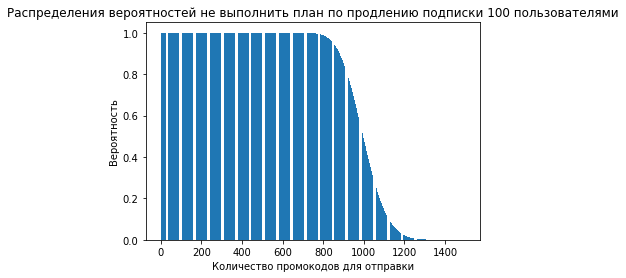

In [51]:
#строим график биномиального распределения
k=99
p=0.1
distr=[] #создаём список distr, в котором будет храниться значения распределения

#строим распределение вероятностей
for n in range(0,1500 ):
    current_value = binom.cdf(k,n,p)
    distr.append(current_value)
    s = pd.Series(distr)
print(f'Минимальное количество промокодов: {s[s <= 0.05].index.min()} шт.')

#строим гистограмму распределения вероятностей    
plt.bar(range(0, 1500 ), distr)
plt.title('Распределения вероятностей не выполнить план по продлению подписки 100 пользователями')
plt.ylabel('Вероятность')
plt.xlabel('Количество промокодов для отправки')
plt.show()

- Выполним обратную операцию - найдем количество промокодов с помощью метода ppf().

In [52]:
# указываем среднее значение распределения
mu = n1*p1 
sigma = np.sqrt(n1*p1*(1-p1)) # указываем стандартное отклонение распределения
prob = result # указываем, с какой вероятностью нужно получить результат 

distr = st.norm(mu,sigma) # создаем требуемое распределение

n_shipment = distr.ppf(prob) # рассчитываем методом ppf, сколько промокодов нужно разослать 

print('Минимальное количество промокодов:', int(n_shipment))

Минимальное количество промокодов: 99


###  Push-уведомления

- Задача: 

  - Отдел маркетинга рассылает клиентам **push-уведомления** в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около **40 %** получивших его клиентов. Отдел планирует разослать **1 млн** уведомлений. Нужно с помощью **аппроксимации** построить примерный график распределения и оценить вероятность того, что уведомление откроют не более **399,5 тыс. пользователей**.


- План решения:
  
  - Речь в задаче о **биномиальном распределении**: величины дискретные (количество уведомлений), и набором независимых испытаний по схеме Бернулли (пользователь либо открыл сообщение, либо нет). Такое распределение задается двумя параметрами: **n - количество испытаний (1 млн)** и **p - вероятность успеха (0.4)**. Нормальное распределение задается двумя связанными с биномиальным параметрами: **mu - математическое ожидание (n*p)**  и стандартное отклонение: **sigma (корень из n2 * p2 * (1 - p2))**. Наша **задача построить график** аппроксимации биномиального распределения нормальным, затем **с помощью** метода **sdf() найти вероятность** для заданной случайной величины: **399,5 тыс.**

- Создадим  функцию расчета вероятности проведения успешных экспериментов Бернулли и построим график аппроксимации биномиального распределения нормальным.

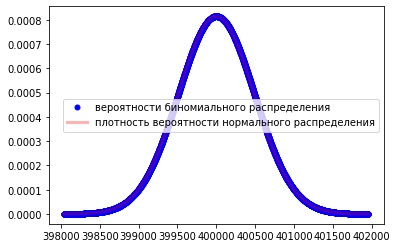

In [53]:
# зададаем функцию, которая выдаёт *num* чисел, 
# равномерно распределённых от *start* до *stop* 
# (понадобится для визуализации нормального распределения).
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n2 = 1000000
p2 = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n2 * p2 - 4 * np.sqrt(n2 * p2 * (1 - p2)))
right = int(n2 * p2 + 4 * np.sqrt(n2 * p2 * (1 - p2)))
 
# зададаем набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))

# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n2, p2), 'bo', ms=5,
        label='вероятности биномиального распределения')

# зададаем параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n2 * p2
sigma = np.sqrt(n2 * p2 * (1 - p2))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, 
        label='плотность вероятности нормального распределения')
 
# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

In [54]:
# задаём параметры биномиального распределения
n2 = 1000000
p2 = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n2 * p2
sigma = np.sqrt(n2 * p2* (1 - p2))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399500 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


### Вывод по седьмому шагу

- Решили задачу на раздачу промокодов: 

  - В цикле **задали параметры** биномиального распределения, с помощью метода **binom()**: **n**(количество испытаний) и **p=0.1**(вероятность успеха) и передали методу кумулятивной функции **cdf()**, пока вероятность продления 100 подписок не достигнет заданного уровня (**95%**). Затем, с помощью вычисленных параметров построили график биномиального распределения. 
  
  - Вывод: чтобы **с вероятностью 95% 100** пользователей **продлили подписку**, необходимо раздать минимум **858** промокодов. 

    
- Решили задачу о рассылке push-уведомлений: 

  - С помощью аппроксимации биномиального распределения нормальным **построили график**, и с помощью методов **norm()** и **sdf() оценили вероятность** заданного события.
  
  - Вывод: **вероятность** того, что **не более 399,5 тыс**. пользователей **из 1 млн. откроют** полученное **уведомление**, составляет **15,37%**.

## Общий вывод

- В ходе работы над проектом, мы:
  
  - Загрузили и изучили данные.

  - Сделали предобработку.
 
  - Провели исследовательский анализ данных.

  - Объединили данные о пользователях, поездках и подписках.

  - Визуализировали информацию о пользователях с подпиской и без неё. 
       
  - Подсчитали выручку пользователей.

  - Сформулировали и с помощью t-тестов проверили несколько гипотез. 

  - Решили два дополнительных кейса на распределения.

  - Сформулировали и оформили промежуточные и общий выводы. 
 
     
**Резюме**     

- **Пользователи с подпиской** имеют хороший и оптимистичный **потенциал для развития**: у них **больше продолжительность поездок** и они **опережают** по расстоянию пользователей без подписки **на коротких дистанциях**, при этом подписчики **оптимально изнашивают самокаты**, а помесячная выручка от них выше, так что, в целом, **подписчики более выгодны** с точки зрения маркетинговых вложений и долгосрочных инвестиций.  